<a href="https://colab.research.google.com/github/tizianofucci/A2NDLSegmentation/blob/main/Notebook/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [3]:
cwd = os.getcwd()

In [4]:
labels_dict  = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}


# Example: Image Segmentation
## Build segmentation

In [5]:
import shutil
import random
import json
import math

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.path.join(os.path.dirname(os.getcwd()),"VQA_Dataset")

#Save all possible path in order to be able to cycle over them
dataset_image_dir = os.path.join(cwd,'Images')

dataset_QA = os.path.join(cwd,'train_questions_annotations.json')

test_QA = os.path.join(cwd,'test_questions.json')


In [6]:
print(dataset_QA)
print(test_QA)

C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\train_questions_annotations.json
C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\test_questions.json


In [7]:
with open(dataset_QA) as f:
    q_dict = json.load(f)

In [8]:
for key in q_dict:
#     q_dict[key]['answer'] = labels_dict[q_dict[key]['answer']]
    print(q_dict[key]['answer'])

man
blanket
bench
yes
man
no
yes
brown
no
no
yes
no
no
1
gray
yes
yes
no
yes
no
soccer
yes
no
3
playing
sitting
food
no
2
man
yes
no
orange
no
1
yes
blanket
2
1
no
red
yellow
no
no
2
no
blue
red
2
2
baseball
yes
yes
nothing
dog
no
yes
no
no
yes
tree
2
stool
yes
no
yes
yes
no
1
yes
yes
2
yes
2
brown
yes
red
yes
yes
red
1
no
yes
1
0
no
red
no
3
2
no
yes
no
yes
woman
log
yes
no
tree
bike
yes
sitting
yellow
no
yes
2
3
no
no
floor
stool
yes
yes
2
yes
yes
yes
yes
red
no
no
no
no
1
no
yes
yes
yes
no
red
yes
yes
no
4
yes
yes
2
nothing
table
1
orange
no
no
standing
red
2
yes
4
no
yes
no
yellow
no
no
yes
no
2
brown
yes
2
blue
2
yes
sleeping
no
plant
apple
black
yes
no
no
yes
no
no
blue
yes
squirrel
3
4
soccer
no
orange
yes
yes
yes
no
grass
yes
left
yes
no
yes
bone
no
yellow
orange
no
no
red
girl
2
no
red
yes
2
white
log
yes
white
yellow
2
no
yes
yes
1
5
table
2
no
wine
yes
yes
blue
no
1
2
1
yes
4
table
red
1
yes
yes
2
no
nothing
no
couch
no
2
1
yes
yes
yes
yes
blue
3
5
5
0
brown
red
sandbox
yes


2
2
blue
bike
orange
wine
3
cat
yes
blue
yes
2
4
tree
yes
2
yes
table
yes
no
yes
yes
2
red
1
no
red
yes
white
yes
yes
no
yes
yes
yes
yes
woman
no
yes
red
no
1
yes
1
bench
yes
3
white
yes
red
2
3
4
standing
no
yes
yes
no
yes
yes
grass
2
0
yes
yes
yes
yes
2
yellow
red
1
1
yes
no
1
red
no
yes
yellow
white
woman
yes
yes
2
yes
no
yes
yes
no
food
yes
no
yes
red
yes
cat
red
yes
1
green
yes
green
no
gray
nothing
2
1
yes
yes
yes
yes
no
no
wine
dog
no
yes
no
1
left
brown
no
yes
3
yes
white
yes
girl
no
brown
2
no
no
1
yes
gray
no
no
2
2
dog
yes
football
blue
no
3
no
1
yes
2
gray
yes
nothing
5
2
sitting
no
1
no
3
yes
no
floor
yes
yes
yes
yes
tree
no
no
blanket
3
white
1
dog
2
no
no
yes
2
no
red
yes
sunny
no
yes
no
yes
red
no
yes
white
no
no
girl
no
no
0
2
1
sitting
3
yes
yes
yes
yes
2
yes
white
1
white
bench
red
yes
football
yes
white
no
1
2
1
yes
bike
no
5
yes
yes
no
yes
no
no
1
yes
yes
yes
yes
yes
red
no
right
table
1
yes
red
3
3
white
yes
1
white
yes
standing
no
no
yes
0
yes
watermelon
yes
cat


no
yes
1
tree
yes
yes
no
yes
tree
2
yes
brown
red
yes
yellow
red
green
white
no
yes
watermelon
yes
yellow
no
no
no
yes
dog
2
2
soccer
yes
yes
yes
yes
yes
rug
yes
no
yes
2
no
no
yes
no
1
no
brown
yes
no
2
yes
yes
2
yellow
no
red
no
no
baseball
5
soccer
yes
no
5
yes
yes
no
yes
no
football
yes
yes
yes
2
2
1
yes
no
3
1
no
yes
orange
yes
no
5
0
no
yellow
yes
2
yes
5
man
no
2
3
2
yes
white
2
sleeping
standing
blue
cat
no
no
orange
yes
no
no
no
yes
brown
no
yes
no
no
yes
playing
yes
2
yes
yes
1
yes
2
no
no
green
yes
4
yes
plant
yes
yes
no
boy
1
no
2
no
brown
no
2
yes
yes
no
no
no
dog
0
yes
yes
black
3
yellow
1
blue
couch
yes
no
yes
2
red
no
green
no
no
cat
no
food
2
yes
yes
bench
no
no
yes
no
0
yes
table
yes
bird
no
yes
brown
wine
sitting
1
brown
no
yes
2
yes
red
yellow
woman
no
bike
brown
yes
yes
1
playing
soccer
yes
2
yes
yes
gray
4
sitting
no
no
yes
white
wine
cat
yes
2
dog
left
couch
red
dog
yes
red
5
no
sandbox
2
yes
no
yes
2
3
2
yes
cat
yes
watermelon
yes
no
no
no
blue
no
no
no
yes
red


no
no
nothing
yes
yes
tree
yes
standing
2
no
no
bird
watermelon
no
no
1
no
yes
3
no
yes
2
no
red
no
dog
red
no
yes
no
5
no
no
2
no
blanket
yes
yes
no
yes
pie
yes
0
1
right
red
blue
no
yes
no
yes
no
yes
yes
orange
2
4
white
4
blanket
no
0
yes
watermelon
yes
no
2
brown
2
no
4
yes
couch
left
no
yes
yes
yes
yes
rug
no
no
no
woman
brown
red
2
plant
no
yes
yes
floor
yes
yes
yes
green
no
2
no
4
red
2
red
yes
no
no
squirrel
wine
white
no
white
no
yes
red
no
no
table
right
no
tree
squirrel
baseball
1
yes
4
gray
no
blue
yes
sunny
yes
2
yes
no
orange
bench
yes
no
tree
green
yes
no
no
no
girl
yes
no
no
yes
3
yes
yes
yes
blanket
blanket
3
yes
yes
no
right
no
yes
3
sandbox
1
no
orange
2
no
bird
red
yes
no
no
2
yes
no
4
yes
0
couch
table
couch
white
no
yes
grass
no
2
stool
yes
2
yes
book
standing
yes
yes
tree
playing
yellow
3
5
no
1
yes
yes
yes
no
bone
no
yes
no
0
yes
yes
green
yes
no
left
yes
2
cat
yes
no
yes
white
no
yes
yes
no
yes
yes
yes
blue
dog
yes
yes
1
yes
2
no
yes
blue
3
no
4
yes
food
no
log

no
black
green
no
yes
no
brown
blue
yes
soccer
yes
2
3
yes
2
yes
no
yes
no
4
5
yes
black
yes
2
2
yes
no
no
sunny
no
blue
yes
monkey bars
sunny
5
1
no
yes
yellow
yes
yes
nothing
2
sitting
no
1
yes
no
red
yes
yes
yes
floor
yes
no
yes
brown
3
yes
no
yes
monkey bars
2
man
right
white
no
yes
no
yes
squirrel
gray
4
no
no
yes
yes
yes
log
yes
yes
yes
yes
no
yes
no
4
no
yes
green
no
no
no
yes
food
yes
1
sitting
yes
no
3
chair
no
yes
nothing
2
1
yes
bench
yes
yes
yes
yes
yes
plant
yellow
2
1
2
football
man
red
cat
yes
no
woman
tree
yes
2
tree
sleeping
2
no
no
no
no
2
yes
no
3
2
2
green
red
3
5
cat
yes
yes
1
yes
no
2
blanket
yes
no
yes
2
yes
football
brown
log
2
0
yes
yes
yes
1
yes
woman
yes
no
tree
food
2
no
yes
yes
yes
1
2
rug
yes
yes
no
yes
no
yes
yes
yes
yes
yes
yes
no
yes
monkey bars
red
nothing
yes
yes
floor
red
yes
yes
yes
no
2
no
red
table
white
yes
yes
yes
red
cat
cat
bird
sitting
yes
yes
yes
sleeping
yes
2
yes
no
1
yes
orange
yes
yes
yes
no
wine
3
no
red
4
no
1
yes
yes
no
blue
brown
no


tree
yes
no
yes
yes
yes
yes
yes
white
yes
yes
plant
no
sitting
left
no
white
yes
no
1
1
no
2
yes
1
yes
cat
no
2
no
yes
4
yes
yes
yes
yes
yes
yes
yes
black
yes
2
yes
no
blue
yes
dog
2
bone
1
no
no
yes
no
orange
floor
yes
no
red
yellow
yes
brown
no
yes
yes
left
table
no
1
bike
soccer
3
3
gray
yes
1
yes
no
yes
yes
yes
yes
playing
no
no
yes
yes
boy
no
no
red
no
yes
playing
green
blue
yes
yes
yes
2
yes
no
yes
bike
2
dog
yes
yes
1
no
yes
4
no
no
yes
right
2
soccer
yes
yes
no
2
no
yes
no
yes
4
monkey bars
yes
yes
yes
yes
yes
yes
5
yes
left
no
yes
yellow
no
blanket
nothing
1
no
no
yes
right
1
man
dog
yes
girl
yes
no
no
red
1
yes
yes
monkey bars
brown
1
yes
yellow
no
2
no
1
yes
nothing
tree
yes
yes
3
no
yes
no
black
2
yes
no
wine
cat
wine
yes
1
3
yes
2
no
sitting
1
yes
sitting
white
no
yes
yes
white
no
yes
dog
yes
2
2
monkey bars
yes
yes
no
yes
yes
no
table
no
sleeping
yes
3
yes
dog
yes
2
no
couch
2
2
yes
no
football
yes
football
no
no
couch
1
4
red
no
red
bike
couch
yes
no
tree
3
no
cat
blue
n

1
red
3
yes
plant
1
yes
yes
no
yes
3
red
2
yes
no
baseball
no
yes
no
1
sleeping
no
yes
yes
yes
dog
no
yes
no
no
no
standing
man
yes
0
white
log
tree
2
yes
boy
yellow
red
no
3
yes
white
white
cat
no
red
blue
yellow
yes
no
bone
red
soccer
gray
yes
no
yes
yes
1
yes
2
no
0
yes
sitting
no
red
no
yes
sitting
couch
yes
yes
yes
3
no
yes
left
yes
right
yes
yes
1
yes
no
2
yes
yes
yes
no
white
0
log
1
table
no
no
no
yes
no
yes
white
red
yes
3
no
orange
yes
no
no
2
yes
2
sitting
1
0
yes
left
no
no
no
yellow
yes
1
white
yes
no
brown
chair
yes
no
no
no
yes
no
yes
yes
no
no
yes
yes
no
yes
no
2
football
4
no
no
yes
yes
no
no
nothing
yes
no
yes
yes
dog
no
2
red
no
yes
0
yes
no
floor
black
yes
no
2
no
1
no
nothing
floor
yes
green
bird
0
no
red
red
dog
floor
no
no
bird
red
yes
cat
2
green
no
no
orange
5
floor
no
football
no
2
yes
yes
yes
yes
2
yes
wine
no
yes
sunny
yellow
no
dog
woman
no
yes
1
3
no
yes
yes
gray
1
red
yes
blue
white
wine
table
yes
no
yes
0
yes
no
2
no
red
squirrel
no
3
3
no
2
floor
yes
1


yes
bike
yes
no
blue
4
no
yes
yes
red
yes
cat
1
red
table
table
yes
no
yes
yes
rug
rug
nothing
soccer
yes
2
white
no
grass
3
red
yes
yes
red
blue
no
yes
no
yes
yes
yes
no
black
floor
yes
yes
0
yes
couch
yes
yes
yes
red
no
no
yes
yes
red
woman
no
brown
no
right
4
2
no
yellow
2
yellow
sitting
yes
girl
no
yes
3
yes
yes
yes
no
4
cat
2
2
no
monkey bars
3
no
3
cat
no
football
yes
3
no
rug
yes
no
yes
no
yes
yes
white
white
yes
sandbox
yes
wine
yes
no
cat
no
no
yes
2
no
yes
yes
yes
yellow
yes
yes
yes
yes
yes
2
no
no
5
4
yes
yes
chair
yes
woman
floor
squirrel
right
yes
white
2
white
no
yes
red
3
no
yellow
no
stool
white
2
1
2
red
no
yes
no
woman
red
no
yes
man
1
yes
yes
yes
no
yes
no
no
2
yes
yes
yes
red
no
yes
baseball
gray
yellow
dog
yes
no
2
dog
yes
plant
sleeping
black
2
girl
yes
food
right
rug
couch
yes
2
5
yes
log
yes
no
red
yes
yes
yes
pie
yes
no
no
white
yes
wine
red
no
no
yes
yes
pie
bird
no
yes
no
yes
yes
yes
red
yes
no
no
yes
1
no
no
yes
no
1
no
yes
left
no
no
1
yes
chair
sleeping
ye

no
red
2
red
yes
yes
yes
no
yes
yellow
squirrel
yes
2
yes
yes
yes
yes
soccer
black
no
0
yes
yes
yes
wine
no
no
no
no
yes
2
yes
sleeping
rug
2
yes
1
1
yes
couch
red
2
2
no
4
no
no
no
no
no
sandbox
boy
yes
no
yes
yes
no
no
yes
yes
right
2
1
3
yes
1
no
yes
right
yes
red
3
3
no
white
yes
no
yes
2
brown
blue
soccer
2
yes
no
yes
yes
2
2
2
blue
yes
floor
floor
orange
0
bench
yes
no
yes
yes
yes
yes
2
yes
bench
no
standing
1
yes
yes
no
cat
yes
no
yes
floor
0
yes
1
white
yes
no
no
no
yes
no
yes
no
yes
yes
yes
blue
3
yes
plant
yes
yes
boy
blue
yes
nothing
brown
yes
cat
no
white
yes
left
yes
yes
cat
yes
yes
no
no
yes
no
yes
4
no
yes
sandbox
yes
no
0
rug
3
yes
football
bike
no
wine
2
yes
2
4
bone
2
no
no
yes
no
wine
1
blanket
no
yes
dog
white
floor
no
right
no
no
yes
red
wine
1
yes
blue
1
book
woman
yes
1
gray
yellow
no
watermelon
2
yes
yellow
yellow
yes
plant
4
no
yes
wine
red
green
nothing
no
no
2
2
chair
blue
yes
no
yes
bike
floor
yes
sunny
blue
1
no
cat
2
white
right
yes
dog
yes
yes
blanket
gre

yes
no
yes
2
sleeping
no
no
5
0
yes
girl
3
white
yes
yes
yes
woman
no
no
yes
bone
2
blue
yes
yes
no
food
5
pie
yes
yes
no
yes
no
yes
2
cat
couch
couch
no
cat
5
floor
yes
no
yes
yes
yes
no
no
no
yes
gray
0
yes
no
playing
brown
yes
yes
no
2
yes
floor
no
no
no
yes
no
no
yes
no
dog
yes
yes
4
no
watermelon
no
2
1
wine
monkey bars
playing
no
yes
yes
yes
dog
no
5
yes
no
yes
bike
gray
no
yes
yes
yes
brown
3
no
cat
chair
yes
yes
yes
red
no
3
couch
no
woman
no
dog
soccer
3
4
yes
baseball
red
yes
red
1
nothing
yes
stool
no
red
no
2
5
2
2
2
yes
food
yes
3
yes
sunny
yes
2
2
table
yellow
playing
3
stool
dog
3
blue
yes
2
no
yellow
yes
no
no
red
yes
dog
no
3
yes
yes
no
red
yes
no
3
2
yes
2
yes
brown
yes
no
dog
yes
brown
yes
2
white
yes
squirrel
yes
red
yes
yes
2
yes
red
red
no
red
yes
girl
yes
2
3
1
no
yes
no
red
2
1
yes
no
3
yes
no
no
yes
no
yes
no
2
yes
no
no
yes
no
no
bike
no
yes
yellow
yes
yes
no
yellow
1
bird
no
1
3
yes
yes
no
black
no
3
sitting
bird
yes
no
yes
2
no
yes
yes
1
dog
blue
yes
yes
3
c

no
yes
yes
red
2
no
yes
yes
3
blue
yes
yes
yes
no
no
1
no
yes
floor
no
dog
yes
no
yes
yes
yes
4
yellow
no
yes
bone
yes
yes
yes
no
3
3
sunny
2
yes
no
table
brown
yes
3
brown
no
yes
yes
no
no
red
yes
1
0
couch
yes
cat
sleeping
yes
no
sandbox
no
no
2
dog
couch
yes
yes
yes
red
cat
no
yes
bike
yes
yes
yes
wine
no
no
5
2
2
bench
wine
yes
yes
2
red
3
2
chair
yes
no
2
no
no
yellow
1
yes
no
no
yellow
white
no
2
yes
2
woman
yes
no
2
yes
2
stool
2
yes
yes
yes
standing
yes
pie
pie
1
4
yes
no
2
yes
2
yes
gray
yes
no
yes
plant
yes
bird
bird
no
no
no
red
bench
no
bird
yes
dog
white
girl
no
watermelon
4
2
0
no
2
white
right
dog
black
1
no
no
black
2
no
2
yes
yes
no
dog
yes
red
white
green
2
monkey bars
bird
no
no
no
standing
stool
wine
yes
wine
2
yes
yes
white
yellow
yes
sleeping
yes
blue
book
no
no
no
4
yes
yes
no
white
yes
yes
no
red
soccer
no
sunny
yes
3
no
brown
3
no
yes
bike
grass
orange
4
no
1
yellow
no
sleeping
4
no
sitting
no
floor
no
red
no
no
yellow
monkey bars
blue
cat
2
yes
no
no
no
yes
ye

yes
yes
rug
sitting
2
yes
red
yellow
1
yes
4
yes
man
yes
2
yes
yellow
no
no
no
0
white
standing
5
1
no
couch
red
2
yes
yes
no
red
3
yes
no
yes
no
yes
no
3
yes
yes
2
sitting
red
log
1
yes
yes
yes
no
5
3
yes
yes
yes
5
no
sleeping
no
squirrel
cat
2
dog
no
no
yes
no
yes
yes
white
no
4
yes
apple
no
baseball
no
right
no
yes
no
no
no
no
man
no
no
white
no
white
floor
yes
no
soccer
no
no
no
rug
yes
2
no
no
no
brown
right
yes
nothing
red
yellow
yes
baseball
white
no
bone
bone
yes
yes
4
soccer
yes
2
blue
yellow
2
4
no
yes
table
3
no
yes
yes
3
no
2
chair
no
4
red
left
no
yes
no
yes
monkey bars
yes
bench
no
woman
4
no
white
yes
no
soccer
3
no
yes
no
no
yes
2
yes
stool
sitting
plant
yes
no
yes
right
no
yes
yes
1
yes
no
red
food
watermelon
dog
girl
no
yes
yes
no
no
2
no
yes
blue
sunny
no
red
yes
yes
apple
2
yes
dog
2
yes
3
yes
yes
no
no
3
blue
yes
girl
3
no
log
2
no
rug
2
apple
no
football
yes
yes
yes
white
floor
yes
yes
2
yes
white
no
yes
no
red
no
yes
no
yes
4
white
black
nothing
1
chair
left
slee

3
wine
yes
yes
no
2
2
3
yes
2
boy
no
boy
yes
cat
2
red
yes
wine
no
yes
2
no
yes
no
no
no
0
blue
no
yes
2
yes
2
no
1
4
2
squirrel
yes
apple
no
log
football
sitting
football
1
yes
yes
yes
1
no
yes
no
no
yes
yes
yes
red
no
yes
yes
soccer
yes
3
yes
no
black
no
white
no
no
1
no
yes
yes
white
no
no
yes
2
gray
2
no
sunny
yes
3
no
no
2
yes
no
girl
yes
no
2
5
yes
yes
no
yes
yes
yes
yes
yes
no
3
yellow
yes
3
4
2
no
left
no
football
no
no
yes
yes
playing
yes
girl
no
blue
no
1
yes
2
1
1
no
yes
no
no
yes
2
no
0
no
no
0
1
red
no
log
no
no
yes
yes
no
3
white
boy
squirrel
1
yes
1
blue
1
yes
yes
2
yes
yes
yes
no
green
yes
no
2
no
yes
no
yes
5
yes
cat
brown
1
pie
3
no
white
no
no
brown
yes
dog
no
playing
playing
2
white
yes
yes
2
yes
yes
2
yes
dog
yes
yes
2
yes
table
yes
yes
stool
yes
red
yes
yes
right
yes
2
yes
black
1
white
red
yes
0
orange
2
yes
woman
yes
yes
rug
yes
yes
no
bone
1
no
yes
yes
bird
white
red
no
red
yes
table
yes
yes
no
log
sleeping
standing
yes
3
yes
no
cat
yes
gray
2
1
yes
yes
woman
y

no
dog
yes
no
red
no
book
sleeping
no
yes
black
yes
no
no
1
yes
stool
2
wine
no
tree
yes
1
red
yes
3
no
yes
no
floor
no
bike
3
no
cat
orange
yes
yes
no
3
no
2
yes
no
chair
0
white
yes
plant
no
4
no
2
1
no
yes
no
yes
yes
yes
yes
yes
apple
yes
2
no
2
2
no
1
yes
food
red
no
2
1
brown
2
no
yes
green
white
pie
log
yes
boy
yes
monkey bars
yellow
no
yes
black
yes
no
dog
yes
no
no
yes
4
yes
yes
no
1
5
yes
yes
yes
red
1
yes
yes
yes
2
1
yes
no
no
white
yes
red
yes
yes
1
yes
4
yes
no
cat
no
no
soccer
green
yes
2
2
blue
yes
yes
brown
2
girl
yes
yes
nothing
no
baseball
2
3
yes
2
no
no
yes
yes
no
yes
0
yes
plant
yes
no
yes
no
no
no
yes
3
2
4
couch
yes
2
2
yes
2
2
2
sandbox
yes
black
3
no
yes
1
yes
black
yes
1
no
yes
grass
tree
yes
yes
1
no
yes
no
1
2
dog
yes
1
no
no
cat
yes
yes
yes
sitting
girl
3
no
3
cat
yes
5
yes
yes
yes
1
yes
red
brown
4
yes
yes
yes
boy
yes
1
yes
4
yes
yes
yes
no
no
yes
0
log
grass
no
no
no
no
yes
yes
brown
no
yes
0
red
stool
2
food
yes
no
yes
no
yes
no
1
no
4
brown
yes
blanket
n

red
log
yes
watermelon
2
no
squirrel
2
brown
yes
yes
1
yes
boy
no
1
red
man
no
1
no
red
yes
girl
tree
yes
yes
no
no
white
yes
no
dog
yellow
no
white
3
no
3
yes
no
brown
sitting
no
no
watermelon
woman
yes
cat
yes
blanket
no
green
2
yes
no
no
yes
yes
gray
yes
2
yes
red
no
girl
no
standing
yes
yes
no
yes
no
yes
football
couch
1
no
blue
log
yes
blue
no
yes
yes
red
3
no
2
yes
boy
soccer
no
yes
no
1
2
dog
wine
2
playing
2
yes
2
blue
yellow
yes
no
yellow
yes
dog
girl
2
2
yes
yes
cat
watermelon
no
4
dog
yes
yes
no
no
blanket
yes
no
squirrel
yes
no
no
football
yes
no
yes
yes
yes
4
blue
yes
yes
no
no
1
2
yes
yellow
no
no
blue
yes
2
no
dog
white
nothing
sitting
yes
green
yes
yes
green
yes
sitting
blue
yes
yes
yes
no
2
yes
yes
3
monkey bars
yes
no
no
no
sitting
red
sandbox
yes
2
yes
book
floor
orange
3
football
no
dog
red
yes
yes
yes
blue
couch
3
2
5
no
yes
2
no
no
yes
red
red
yellow
no
no
1
no
no
yes
no
3
yes
2
2
no
dog
no
no
yes
1
no
yes
cat
3
white
no
no
0
yes
yes
red
bird
no
yes
yes
red
yes
bl

yes
white
yes
2
3
yes
yes
1
pie
2
boy
wine
no
no
soccer
0
no
2
no
boy
no
1
no
1
no
yes
football
red
football
yes
green
no
yes
rug
yes
yes
blanket
sandbox
no
yes
yes
2
yes
2
no
1
red
yes
yes
squirrel
blue
sitting
yes
no
no
yes
blue
squirrel
yes
yes
no
no
yes
yes
bird
no
red
no
yes
playing
white
red
white
right
yes
white
no
yes
bike
yes
sitting
yes
yes
red
2
no
red
yes
yes
boy
no
yes
no
yes
2
no
0
watermelon
2
no
yes
yes
yes
yes
no
chair
sitting
yes
no
white
yes
3
yes
yes
no
no
blue
no
football
5
2
yes
1
1
no
no
blue
red
no
no
yes
2
1
2
0
5
yes
1
apple
yes
cat
red
no
no
no
no
blue
no
no
no
white
yes
3
no
no
2
soccer
yes
no
sitting
couch
wine
yes
1
cat
1
1
yes
no
no
yes
floor
wine
rug
rug
yes
1
5
boy
yes
no
apple
yes
cat
red
2
yes
white
2
yes
yes
bench
0
no
yes
pie
yes
no
1
bird
red
yes
white
baseball
3
yes
yes
no
yes
5
dog
no
no
yellow
sleeping
no
right
brown
brown
yes
yes
yes
no
monkey bars
playing
red
no
yes
no
yes
monkey bars
yes
4
2
no
yes
yes
no
no
yellow
yes
yes
no
red
log
yes
brow

white
yes
no
yes
rug
2
4
no
no
football
dog
3
yes
log
pie
no
yes
no
no
couch
right
right
3
red
2
dog
bike
yes
brown
white
4
yes
black
no
brown
1
no
no
2
yes
no
yes
3
cat
monkey bars
wine
yes
sitting
red
yes
log
brown
white
no
yes
standing
yes
2
no
yes
no
no
bike
yes
bike
floor
wine
yes
no
no
yes
red
1
couch
no
1
yes
brown
no
couch
yes
yes
yes
floor
red
yes
3
no
1
yes
no
no
red
yes
blue
no
red
no
no
no
no
3
4
no
yes
yes
2
yes
2
playing
woman
bench
yes
black
red
1
no
no
1
couch
1
yes
yes
2
no
2
yes
1
2
yes
yes
no
white
dog
no
1
yes
2
standing
yes
no
yes
no
no
baseball
red
no
yes
2
no
no
no
red
1
food
yes
yes
yes
1
2
sitting
no
yes
yes
no
yes
no
girl
yes
bone
yes
no
floor
1
no
yes
yes
cat
1
bench
blue
no
yes
couch
no
no
yes
2
1
blue
3
no
yes
2
yes
yes
yes
yes
yes
no
dog
no
yes
yes
sleeping
red
floor
white
black
no
2
no
yes
3
2
no
yes
tree
1
brown
3
2
no
sitting
no
no
left
yes
standing
2
no
no
bike
red
5
yes
yes
no
blue
no
gray
yes
no
no
yes
no
woman
red
yes
no
yes
2
2
yes
yes
blanket
2
bl

yes
no
white
red
2
yes
yes
yes
bench
yes
yes
yes
yes
no
yes
red
yes
0
standing
no
red
no
yes
4
2
yes
yes
2
3
2
white
no
2
yellow
yes
no
yes
left
white
2
bike
yes
yes
4
no
no
yes
1
yes
yes
yes
girl
yes
yes
bench
yes
1
yes
2
sitting
yes
1
no
no
white
yes
no
yes
no
yes
yes
no
yes
left
red
no
sleeping
3
no
yes
left
yellow
nothing
1
yes
3
no
black
sunny
black
3
blue
bike
yes
2
2
no
no
stool
yes
no
yes
table
yellow
yes
red
red
no
5
black
yes
yes
no
brown
2
no
nothing
sleeping
yes
yellow
yes
yes
no
2
tree
yes
no
yes
2
2
no
yes
no
yes
yes
yes
no
yes
yes
no
orange
yes
yes
2
no
white
orange
no
yes
yes
yes
stool
no
sleeping
brown
yes
3
yes
girl
soccer
yes
dog
no
2
cat
white
blue
sitting
no
2
yes
yes
yes
cat
3
0
2
tree
no
no
no
no
no
2
4
4
yes
yes
yes
cat
yes
no
yellow
soccer
soccer
yes
2
no
no
no
3
no
yes
no
1
no
1
no
yes
yes
yes
floor
no
yes
2
girl
yes
yes
yes
no
yes
gray
no
1
no
no
2
4
floor
red
yes
3
yes
yes
yes
yes
cat
grass
yes
3
yes
no
yes
2
food
yes
wine
no
no
4
white
2
brown
boy
yes
3
no


3
yes
4
3
girl
couch
sleeping
yes
no
2
yes
blue
5
blanket
no
yes
yes
yes
yes
no
yes
no
no
dog
no
yes
no
watermelon
pie
yes
yes
no
no
football
2
4
sitting
yes
no
yes
no
2
3
0
yes
yes
yes
no
yes
no
no
2
no
nothing
no
4
yes
blue
yes
yes
grass
2
dog
no
yes
no
right
red
no
blue
football
yes
yes
floor
yes
no
yes
0
yes
yes
no
sitting
man
5
2
no
yes
no
dog
2
yes
1
no
3
red
1
red
2
yes
yes
2
3
2
yellow
no
yes
2
soccer
yes
orange
3
no
red
3
no
2
no
yes
watermelon
no
yes
rug
3
yes
woman
wine
cat
apple
rug
yes
log
apple
yes
nothing
dog
blue
black
yes
yes
yes
blue
no
yes
1
no
1
yes
man
no
girl
no
1
yes
bird
yes
yes
3
cat
5
yellow
no
no
bench
0
3
yes
bone
yes
yes
cat
white
yes
yes
no
2
yes
2
sleeping
yes
food
yes
2
yes
red
2
3
2
2
yes
yes
no
no
bench
yes
yes
yes
table
table
yes
yes
yes
no
no
yes
2
yes
sitting
1
yes
yes
blue
squirrel
5
yes
1
yes
no
nothing
no
no
food
boy
yes
3
yes
yes
yes
playing
no
yes
yes
no
yes
yes
couch
yes
grass
yes
yes
no
no
yes
yes
no
brown
3
yes
yes
girl
soccer
yes
yes
no
rug

blue
yes
yes
2
white
yes
no
5
yes
yes
yes
yes
yes
wine
yes
yes
2
right
yes
yes
yes
yes
2
yes
2
yes
dog
yes
no
yes
2
yes
yellow
yes
1
gray
1
3
yes
no
no
grass
no
monkey bars
no
1
yes
yellow
1
man
yes
yes
sandbox
yes
white
yes
yes
red
no
1
yes
yes
red
no
soccer
yes
yes
no
playing
squirrel
yes
white
yes
no
brown
gray
1
no
yes
no
red
yes
sunny
yes
yes
yes
no
bird
yellow
no
yes
no
cat
yes
cat
sleeping
yes
yes
yes
no
chair
plant
brown
yes
no
no
no
yes
yes
yes
2
yes
nothing
yes
1
no
2
no
1
3
1
2
no
football
sandbox
sunny
2
white
stool
2
yes
yes
2
yes
2
playing
yes
no
no
yellow
no
floor
left
3
couch
wine
2
woman
rug
yes
dog
yes
no
log
yes
sitting
yes
wine
yes
yellow
yes
yes
no
no
2
yes
no
no
4
yes
table
yes
yes
table
right
yes
no
rug
3
red
1
no
2
no
1
2
yes
yes
yellow
brown
no
table
yes
couch
floor
man
no
apple
0
yes
yes
yes
floor
yes
black
yes
yes
0
yes
no
no
no
yes
3
0
no
no
no
red
3
yes
chair
chair
white
yes
yes
bird
bench
no
no
boy
2
blanket
no
no
wine
table
no
sitting
yes
yellow
yes
2
no


green
squirrel
2
no
yes
nothing
yes
1
1
couch
yes
no
no
3
yes
yes
yes
squirrel
squirrel
no
book
yes
no
yes
yes
no
no
yes
yes
yes
yes
standing
no
yes
yes
pie
2
no
yes
yes
tree
no
brown
yes
1
yes
yes
yes
yes
3
yes
dog
2
no
bike
2
no
no
yes
yes
no
yes
2
1
5
no
no
no
no
yes
no
bird
yes
gray
playing
yes
1
yes
blanket
yes
wine
no
yes
yellow
baseball
yes
yes
no
no
yes
no
yes
bird
red
yes
2
yes
sleeping
yes
yes
brown
2
yes
red
yes
yes
bone
rug
yes
yes
woman
no
yes
orange
no
2
3
apple
4
yes
orange
yes
brown
red
no
football
no
no
no
red
red
2
squirrel
yes
3
yes
yes
yes
no
wine
food
yes
yellow
5
yellow
yes
yes
orange
yes
no
4
couch
4
table
yes
no
no
yes
no
red
3
yes
sandbox
yes
yes
yes
1
no
no
3
no
yes
boy
yes
no
yes
yes
2
yes
yes
1
5
yes
2
2
2
2
no
cat
grass
yes
yes
rug
no
2
no
yes
2
yes
yes
no
yes
yes
2
no
2
yes
dog
yes
yes
2
yellow
no
yes
woman
yes
1
cat
no
no
black
yes
yes
pie
2
no
2
no
no
yes
man
yes
3
right
no
yes
log
yes
no
no
yes
couch
yes
no
yes
bench
no
2
yes
2
yes
no
yes
yes
2
soccer
2

no
soccer
1
dog
red
no
no
no
yes
no
no
yes
3
yes
white
yes
dog
no
baseball
dog
cat
yellow
yes
blue
no
dog
orange
no
dog
yes
couch
red
yes
yes
yes
1
yes
yes
left
playing
2
yes
no
no
red
floor
orange
yes
yes
yes
no
yes
2
no
yes
yes
yes
no
blue
no
stool
no
left
red
gray
no
dog
yes
yes
no
no
playing
yes
no
wine
yellow
yes
yes
log
yes
yes
no
squirrel
1
yes
blue
4
white
green
football
football
boy
grass
tree
grass
no
yes
woman
yellow
black
no
yes
soccer
no
no
brown
no
3
yellow
yellow
2
sleeping
yes
right
no
football
right
yes
tree
bird
no
yes
table
left
yes
yes
yes
2
yes
no
bike
no
no
woman
yes
yes
yellow
no
yes
yes
yes
3
2
no
yes
no
blue
yes
no
no
girl
left
no
yes
4
no
yes
woman
yes
pie
no
food
no
yes
2
yes
no
bird
no
nothing
2
no
4
blue
bird
yes
yes
yes
yes
2
1
no
no
3
sitting
yes
yes
no
no
yes
yes
sitting
no
no
black
brown
no
yes
2
couch
no
yes
yellow
no
white
yes
1
sitting
yes
2
no
yes
2
bench
white
yes
3
0
no
4
gray
yes
no
yes
no
gray
yes
yes
no
3
no
no
no
no
yes
yes
no
no
no
no
no
yes


yes
no
no
yes
yes
white
yes
brown
cat
apple
yes
no
2
table
no
yes
yes
3
yes
3
4
woman
yes
3
black
no
white
2
boy
yellow
no
5
5
nothing
yes
football
yes
no
dog
yes
yes
couch
yes
black
yes
yes
2
dog
no
no
yes
chair
sitting
yes
4
no
yellow
no
1
no
brown
sitting
no
yes
sitting
4
no
black
red
no
table
yellow
bird
2
yes
no
yes
yes
3
bird
yes
yes
orange
log
table
no
watermelon
2
yes
4
1
soccer
yes
bench
2
yes
2
no
yes
yes
no
yes
no
yes
blue
no
yes
yellow
floor
sandbox
football
no
no
no
no
2
no
no
3
no
red
yes
0
yes
right
2
yes
no
yes
yes
no
yes
yes
1
2
apple
log
yes
white
monkey bars
2
yes
no
yes
no
no
yes
grass
no
yes
yes
wine
wine
book
wine
sandbox
girl
yes
yes
yes
no
4
couch
left
sitting
black
2
orange
no
yes
yes
yes
yes
yes
no
sleeping
no
no
yes
2
4
2
log
no
yes
no
cat
2
yes
no
yes
yes
yes
no
yes
no
no
yes
no
yes
1
no
yes
blue
sleeping
1
no
5
yes
yes
yes
yes
white
no
yes
no
no
bone
yes
yes
3
3
red
red
no
yes
no
yes
1
yes
yes
yes
yes
yes
blue
yes
no
yes
no
yes
yellow
3
brown
yes
1
yes
red


no
yes
dog
yes
2
white
baseball
girl
no
no
yellow
no
no
2
yes
no
2
woman
yes
no
dog
yes
red
yes
yes
no
red
yes
yes
sitting
2
no
no
no
football
blue
yes
cat
white
yes
yes
yes
grass
yes
no
apple
tree
yes
white
no
no
yellow
yellow
yes
blanket
boy
sunny
2
wine
yes
football
no
no
yes
table
yes
2
no
no
blue
1
no
no
yes
2
no
standing
1
table
no
chair
blue
yes
no
yes
log
no
bike
no
yellow
sunny
yes
no
red
2
yes
yes
2
watermelon
grass
no
no
no
yes
couch
yes
2
0
no
green
2
yellow
man
1
yes
no
2
yes
yes
yes
brown
4
no
no
yes
4
blanket
white
2
yes
yes
no
no
yes
3
soccer
no
yes
left
no
yes
1
2
sitting
yellow
grass
no
cat
no
no
no
yes
no
0
yes
no
yes
0
no
table
white
yes
no
yes
3
blanket
no
1
no
no
couch
yes
4
chair
blue
no
3
standing
red
no
yes
man
red
yes
red
3
no
2
plant
gray
cat
yes
stool
no
red
apple
2
2
no
2
soccer
blanket
no
white
no
yes
yes
brown
yes
yes
no
no
no
no
right
yes
sleeping
yes
no
blanket
yes
brown
no
2
brown
football
no
yes
yes
yes
yes
food
yes
no
2
no
yes
yes
no
3
no
bike
yes
ye

no
yes
yes
watermelon
table
yes
yes
1
dog
yes
no
white
no
right
yes
couch
yes
no
yes
2
0
red
1
no
black
no
yes
brown
no
yes
no
yes
2
black
yes
yes
no
no
yes
3
monkey bars
chair
yes
no
white
2
yes
yes
2
yes
table
3
0
2
yellow
yes
yes
gray
green
no
yes
no
no
nothing
squirrel
monkey bars
yes
yes
yes
brown
no
yes
yes
yes
yes
3
no
yes
yes
pie
yes
yellow
no
no
red
yes
2
yes
2
blue
red
soccer
red
red
2
no
yes
5
no
dog
2
2
no
squirrel
red
2
nothing
yes
white
yes
blue
1
no
gray
baseball
yes
cat
2
2
red
wine
yes
2
no
yes
yes
no
yes
no
no
no
yes
no
yes
yes
yes
chair
yes
yes
yes
yes
no
no
woman
blanket
yes
pie
no
red
no
5
red
3
yes
no
yes
nothing
no
no
black
no
yes
brown
yes
no
yes
yes
yes
yes
left
2
no
yes
4
yes
no
1
black
2
brown
yes
no
brown
yes
nothing
no
1
2
squirrel
gray
no
no
soccer
yes
no
3
no
yes
brown
3
yes
red
woman
yes
sleeping
no
red
yes
no
no
4
floor
yes
1
no
no
yes
yes
2
yes
blue
3
black
yes
yes
2
no
yes
2
yes
yes
gray
red
yes
2
black
2
yes
2
yes
no
yes
yes
yes
book
left
floor
yes
o

2
4
blue
no
cat
yes
food
white
yes
1
no
no
yes
no
yes
red
1
yes
2
table
1
dog
no
2
yes
2
no
yes
yes
no
1
log
stool
yes
sunny
baseball
yellow
sandbox
2
bike
no
rug
yes
right
plant
1
right
2
red
rug
yes
yes
white
left
red
football
yes
monkey bars
3
yes
yes
5
yes
yes
red
black
red
no
red
no
rug
yes
wine
0
no
nothing
no
no
no
stool
no
yes
0
yes
log
no
no
green
no
yes
yes
2
2
4
no
yes
yes
yes
yes
no
1
yes
yes
yes
yes
yes
yes
2
brown
brown
yes
log
green
5
no
yes
yes
red
brown
no
2
yes
no
no
3
no
yes
yes
man
no
2
yes
no
no
1
food
yes
blue
yes
yes
2
yes
bird
2
yes
no
no
no
tree
white
red
no
no
couch
boy
0
right
white
no
no
baseball
log
yes
3
no
1
2
woman
2
1
3
2
yes
no
yes
yes
floor
yes
no
wine
2
black
yes
chair
tree
no
4
no
red
yes
dog
nothing
yes
yes
no
yes
yes
yes
blue
no
yes
football
3
no
no
2
yes
no
no
food
yes
no
2
red
watermelon
yes
no
no
yes
no
yes
green
no
black
no
yes
no
yes
no
sitting
white
no
no
white
yes
1
yes
yes
4
brown
no
yes
yes
no
no
blue
blue
white
2
yes
yes
red
no
dog
couch

In [9]:
# Prepare dataset
# ---------------




MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

answers = []
questions = []
eng_sentences_train = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in q_dict:


#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    answer = q_dict[key]['answer']
    question = q_dict[key]['question']

    
    if (len(answer.split(' ')) > MAX_LEN or
          len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    questions.append(question)
    
    answer_arr = np.zeros(58)
    answer_arr[labels_dict[q_dict[key]['answer']]] = 1
    
    q_dict[key]['answer'] = answer_arr
    answers.append(answer)
    
    count += 1

print('Number of questions:', len(questions))

Number of questions: 58832


In [10]:
max(len(sentence.split(' ')) for sentence in questions)

23

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create Tokenizer to convert words to integers
ita_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
ita_tokenizer.fit_on_texts(questions)
ita_tokenized = ita_tokenizer.texts_to_sequences(questions)

ita_wtoi = ita_tokenizer.word_index
print('Total Questions words:', len(ita_wtoi))

max_ita_length = max(len(sentence) for sentence in ita_tokenized)
print('Max question length:', max_ita_length)

Total Questions words: 4641
Max question length: 22


In [12]:
# Pad to max italian sentence length
ita_encoder_inputs = pad_sequences(ita_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", ita_encoder_inputs.shape)


Italian encoder inputs shape: (58832, 22)


In [13]:
count = 0
for key in q_dict:
    q_dict[key]['question'] = ita_encoder_inputs[count]
    count+=1
 

In [14]:
# Build Encoder-Decoder Model
# ---------------------------

EMBEDDING_SIZE = 32

# ENCODER
# -------

encoder_input = tf.keras.Input(shape=[max_ita_length])
encoder_embedding_layer = tf.keras.layers.Embedding(len(ita_wtoi)+1, EMBEDDING_SIZE, input_length=max_ita_length, mask_zero=True)
encoder_embedding_out = encoder_embedding_layer(encoder_input)
#encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=350,return_sequences=True))

#encoder_output = encoder(encoder_embedding_out)
#encoder_states = [h, c]
second_encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256))
second_encoder_output = second_encoder(encoder_embedding_out)



# MODEL
model_lstm = tf.keras.Model(encoder_input,second_encoder_output)

In [15]:
model_lstm.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 32)            148544    
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               591872    
Total params: 740,416
Trainable params: 740,416
Non-trainable params: 0
_________________________________________________________________


In [16]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
else :
    img_data_gen = ImageDataGenerator()


In [17]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

    """
        CustomDataset inheriting from tf.keras.utils.Sequence.

        3 main methods:
          - __init__: save dataset params like directory, filenames..
          - __len__: return the total number of samples in the dataset
          - __getitem__: return a sample from the dataset

        Note: 
          - the custom dataset return a single sample from the dataset. Then, we use 
            a tf.data.Dataset object to group samples into batches.
          - in this case we have a different structure of the dataset in memory. 
            We have all the images in the same folder and the training and validation splits
            are defined in text files.

      """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
                preprocessing_function=None, out_shape=[256, 256]):
        if which_subset == 'training':
            subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
        elif which_subset == 'validation':
            subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
        with open(subset_file, 'r') as f:
            lines = f.readlines()
    
        subset_filenames = []
        for line in lines:
            subset_filenames.append(line.strip()) 

        self.which_subset = which_subset
        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.img_generator = img_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        
        
        
        
        # Read Image
        curr_filename = self.subset_filenames[index]
        element = q_dict[curr_filename]
        image = element['image_id']
        img = Image.open(os.path.join(self.dataset_dir, 'Images', image + '.png'))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        img = img.convert('RGB')
        
        # Resize image and mask
        img = img.resize(self.out_shape)
        

        
       # mask = mask.resize(self.out_shape)
    
        img_arr = np.array(img)
        
        
        
        question = element['question']
        answer = element['answer']
        #print(mask_arr.shape)
  
#         if self.which_subset == 'training':
#             if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                
#                 img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
#                 mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
#                 img_arr = self.img_generator.apply_transform(img_arr, img_t)
                
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
#                 out_mask = np.zeros_like(mask_arr)
#                 for c in np.unique(mask_arr):
#                     if c > 0:
#                         curr_class_arr = np.float32(mask_arr == c)
#                         curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
#                         # from [0, 1] to {0, 1}
#                         curr_class_arr = np.uint8(curr_class_arr)
#                         # recover original class
#                         curr_class_arr = curr_class_arr * c 
#                         out_mask += curr_class_arr
#         else:
    
        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)
        
        pair = {"vgg16_input": img_arr, "zzz_input": question}
        
        return pair, answer

In [18]:
if not os.path.exists(os.path.join(cwd,"Splits/")):
    os.makedirs(os.path.join(cwd,"Splits/"))



import json



# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}

val=[]
train=[]

for key in q_dict:
# image_filenames = next(os.walk(os.path.join(dataset_dir[j],"Images/")))[2]



# for image_name in image_filenames:
    if 100*random.random() < 5:
        val.append(key)
    else:
        train.append(key)

with open(os.path.join(cwd,"Splits","train.txt"), 'w') as file:  # Use file to refer to the file object
    for i in train:
        a = file.write(str(i)+"\n")

with open(os.path.join(cwd,"Splits","val.txt"), 'w') as file:  # Use file to refer to the file object
    for i in val:
        a = file.write(str(i)+"\n")



In [19]:
#Creation of dataset generators (the commented line are the ones for getting also the haricot Dataset)

from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 400
img_w = 700

dataset = CustomDataset(cwd, 'training', 
                        img_generator=img_data_gen, preprocessing_function=preprocess_input, out_shape=[img_w,img_h])

dataset_valid = CustomDataset(cwd, 'validation',
                              preprocessing_function=preprocess_input,out_shape=[img_w,img_h])



In [20]:
#Creation of datasets (the commented line are the ones for getting also the haricot Dataset)


train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=({"vgg16_input": tf.float32, "zzz_input": tf.float32}, tf.float32),
                                               output_shapes=({"vgg16_input": [img_h, img_w, 3], "zzz_input":  22}, 58)
                                              )

bs=18


train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=({"vgg16_input": tf.float32, "zzz_input": tf.float32}, tf.float32),
                                               output_shapes=({"vgg16_input": [img_h, img_w, 3], "zzz_input":  22}, 58)
                                              )

valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [21]:
# Let's test data generator
# -------------------------

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0 0 0 ... 2 93 1]
[0 0 0 ... 0 0 0]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

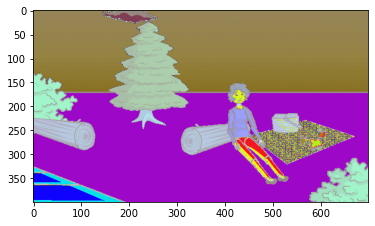

In [22]:

augmented_img = next(iterator)


image = augmented_img[0]['vgg16_input'][0]   # First element

tf.print (augmented_img[0]['zzz_input'][0])
tf.print (augmented_img[1][0])

plt.imshow(np.uint8(image))
plt.plot

In [23]:
#Loading of VGG that will be used as a Backbone
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# for layer in vgg.layers:
#   layer.trainable = False
freeze_until = 18 # layer from which we want to fine-tune

for layer in vgg.layers[:freeze_until]:
    layer.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 700, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 700, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 700, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 350, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 350, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 350, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 175, 128)     0     

In [24]:
# This function is used for creating a model without skip connections
def create_model():

    model = tf.keras.Sequential()
    model2 = tf.keras.Sequential()
    # Encoder
    # -------
    model.add(vgg)
    model2.add(model_lstm)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    
    scores = tf.keras.layers.Multiply()([model.output, model2.output])
    
    denso = tf.keras.layers.Dense(units=90, activation='selu')(scores)

    drop = tf.keras.layers.Dropout(0.3)(denso)
    
    output = tf.keras.layers.Dense(units=58, activation='softmax')(scores)
    
    final_model = tf.keras.Model([model.inputs,model2.inputs], output)


    return final_model

In [25]:
model = create_model()

In [26]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 12, 21, 512)  14714688    vgg16_input[0][0]                
__________________________________________________________________________________________________
functional_1_input (InputLayer) [(None, 22)]         0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 512)          0           vgg16[0][0]                      
_______________________________________________________________________________________

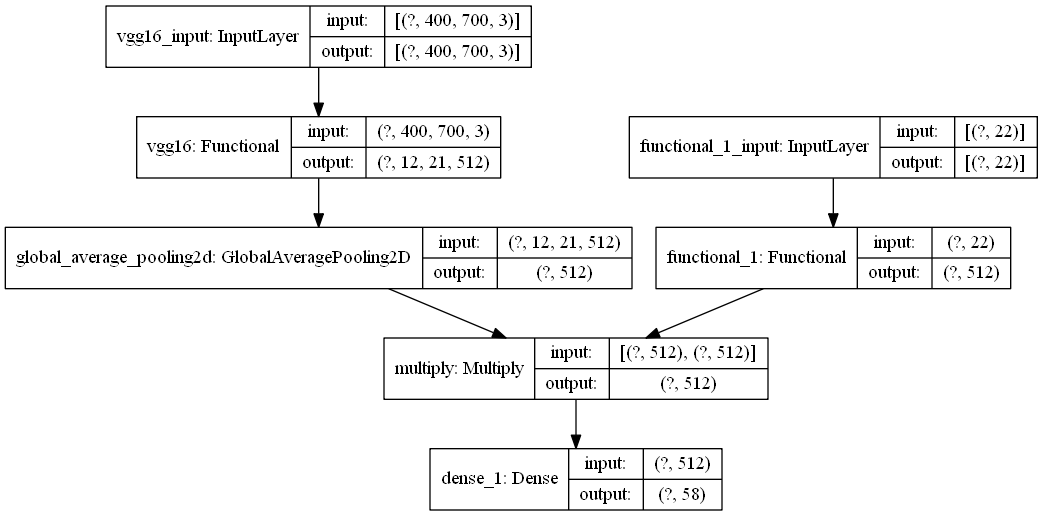

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [28]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.CategoricalCrossentropy() 


# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------


# Validation metrics
# ------------------
metrics = ['accuracy']
# ------------------



# Compile Model
model.compile(optimizer=optimizer, loss=loss , metrics=metrics)

In [29]:
import os
from datetime import datetime

cwd1 = os.getcwd()

exps_dir = os.path.join(cwd1, 'multiclass_exps')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True, save_best_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)/bs,#+len(dataset1)
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/bs, #+len(dataset_valid1)
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
3106/3105 [==============================] - 5436s 2s/step - loss: 1.3036 - accuracy: 0.5109 - val_loss: 1.0286 - val_accuracy: 0.5821
Epoch 2/100
3106/3105 [==============================] - 5445s 2s/step - loss: 0.9476 - accuracy: 0.6131 - val_loss: 0.9616 - val_accuracy: 0.6091
Epoch 3/100
 327/3105 [==>...........................] - ETA: 1:16:49 - loss: 0.8704 - accuracy: 0.6391

KeyboardInterrupt: 

In [33]:

from datetime import datetime

def create_csv(results, results_dir='../results'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [34]:
with open(test_QA) as f:
    test_dict = json.load(f)


MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

test_questions = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in test_dict:

#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    question = test_dict[key]['question']

    
    if (len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    test_questions.append(question)
    
    count += 1

test_tokenized = ita_tokenizer.texts_to_sequences(test_questions)

# Pad to max italian sentence length
test_encoder_inputs = pad_sequences(test_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", test_encoder_inputs.shape)

count = 0
for key in test_dict:
    test_dict[key]['question'] = test_encoder_inputs[count]
    count+=1

Italian encoder inputs shape: (6372, 22)


In [35]:
#Prediction computation done one image at time

#model.load_weights(filepath='C:\\Users\\ASUS\\Documents\\Università\\ANNDL\\A2NDLKaggle\\weights\\FC_Nov14_15-02-54\\ckpts\\cp.ckpt')

from PIL import Image
count = 0
results = {}
for key in test_dict:

    # Read Image
    element = test_dict[key]
    image = element['image_id']
    img = Image.open(os.path.join(cwd, 'Images', image + '.png'))
    #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

    img = img.convert('RGB')
    
    # Resize image and mask
    img = img.resize((img_w,img_h))
    img_arr = preprocess_input(np.array(img))
    question = element['question']
    
    pair = {"vgg16_input": img_arr, "zzz_input": question}  
    
    pair['vgg16_input']=tf.expand_dims(pair['vgg16_input'],0)
    pair['zzz_input']=tf.expand_dims(pair['zzz_input'],0)
    
    predictions = np.argmax(model.predict(pair))
    results[key] = predictions
    print (str(count) + ":" +str(predictions))
    count += 1
create_csv(results)


0:49
1:15
2:2
3:57
4:2
5:0
6:1
7:33
8:57
9:57
10:57
11:28
12:3
13:33
14:33
15:33
16:28
17:57
18:33
19:1
20:57
21:45
22:57
23:2
24:2
25:2
26:57
27:50
28:57
29:33
30:2
31:22
32:33
33:2
34:57
35:57
36:2
37:53
38:57
39:2
40:33
41:56
42:1
43:33
44:44
45:57
46:33
47:57
48:57
49:33
50:1
51:57
52:46
53:57
54:33
55:2
56:2
57:1
58:33
59:33
60:11
61:17
62:41
63:57
64:2
65:39
66:2
67:33
68:54
69:57
70:57
71:33
72:57
73:1
74:32
75:33
76:33
77:53
78:14
79:21
80:57
81:2
82:17
83:57
84:2
85:2
86:32
87:39
88:53
89:56
90:33
91:28
92:30
93:52
94:57
95:33
96:2
97:33
98:11
99:21
100:57
101:57
102:37
103:33
104:33
105:33
106:33
107:1
108:57
109:1
110:2
111:57
112:27
113:52
114:33
115:33
116:43
117:11
118:50
119:28
120:57
121:33
122:1
123:57
124:57
125:57
126:25
127:2
128:2
129:57
130:57
131:2
132:2
133:53
134:26
135:2
136:2
137:2
138:33
139:33
140:3
141:57
142:57
143:34
144:57
145:57
146:2
147:2
148:40
149:57
150:57
151:2
152:2
153:15
154:38
155:33
156:5
157:57
158:9
159:2
160:57
161:2
162:39
163:27
164:48


1195:29
1196:0
1197:21
1198:33
1199:53
1200:33
1201:2
1202:2
1203:32
1204:57
1205:54
1206:53
1207:57
1208:2
1209:57
1210:26
1211:57
1212:21
1213:41
1214:33
1215:2
1216:2
1217:57
1218:33
1219:2
1220:33
1221:57
1222:33
1223:2
1224:33
1225:33
1226:41
1227:33
1228:57
1229:57
1230:4
1231:39
1232:33
1233:33
1234:33
1235:39
1236:57
1237:2
1238:57
1239:57
1240:2
1241:2
1242:53
1243:57
1244:57
1245:33
1246:2
1247:41
1248:23
1249:57
1250:4
1251:2
1252:25
1253:33
1254:5
1255:57
1256:57
1257:18
1258:17
1259:2
1260:33
1261:5
1262:57
1263:57
1264:33
1265:40
1266:57
1267:57
1268:33
1269:33
1270:57
1271:33
1272:43
1273:57
1274:17
1275:57
1276:57
1277:36
1278:2
1279:16
1280:57
1281:37
1282:2
1283:16
1284:33
1285:2
1286:57
1287:33
1288:2
1289:0
1290:2
1291:18
1292:39
1293:2
1294:13
1295:18
1296:55
1297:57
1298:50
1299:21
1300:39
1301:33
1302:4
1303:2
1304:15
1305:39
1306:33
1307:43
1308:2
1309:47
1310:28
1311:56
1312:54
1313:57
1314:2
1315:57
1316:10
1317:36
1318:18
1319:2
1320:2
1321:33
1322:57
1323:33

2249:57
2250:57
2251:33
2252:17
2253:33
2254:57
2255:33
2256:33
2257:33
2258:57
2259:39
2260:33
2261:11
2262:51
2263:29
2264:8
2265:57
2266:23
2267:39
2268:33
2269:33
2270:57
2271:57
2272:21
2273:33
2274:2
2275:2
2276:50
2277:33
2278:57
2279:33
2280:53
2281:55
2282:53
2283:10
2284:18
2285:57
2286:5
2287:39
2288:1
2289:48
2290:2
2291:2
2292:2
2293:14
2294:1
2295:2
2296:33
2297:57
2298:39
2299:33
2300:57
2301:13
2302:2
2303:57
2304:53
2305:57
2306:2
2307:2
2308:18
2309:6
2310:20
2311:57
2312:39
2313:2
2314:2
2315:57
2316:33
2317:53
2318:33
2319:33
2320:33
2321:13
2322:33
2323:33
2324:17
2325:57
2326:17
2327:2
2328:49
2329:33
2330:2
2331:2
2332:17
2333:33
2334:42
2335:2
2336:33
2337:33
2338:2
2339:52
2340:27
2341:18
2342:20
2343:33
2344:25
2345:57
2346:33
2347:27
2348:57
2349:57
2350:39
2351:57
2352:13
2353:2
2354:39
2355:57
2356:57
2357:2
2358:33
2359:33
2360:33
2361:2
2362:50
2363:2
2364:35
2365:57
2366:32
2367:2
2368:2
2369:33
2370:2
2371:47
2372:57
2373:57
2374:2
2375:57
2376:33
2377:

3301:2
3302:57
3303:57
3304:57
3305:57
3306:0
3307:33
3308:57
3309:18
3310:33
3311:57
3312:57
3313:57
3314:33
3315:2
3316:2
3317:4
3318:20
3319:39
3320:47
3321:57
3322:2
3323:57
3324:33
3325:30
3326:57
3327:57
3328:1
3329:33
3330:1
3331:19
3332:56
3333:40
3334:57
3335:2
3336:33
3337:57
3338:57
3339:33
3340:2
3341:33
3342:33
3343:57
3344:2
3345:57
3346:2
3347:2
3348:33
3349:33
3350:41
3351:35
3352:2
3353:28
3354:57
3355:57
3356:2
3357:28
3358:2
3359:33
3360:57
3361:2
3362:55
3363:33
3364:57
3365:33
3366:50
3367:40
3368:57
3369:57
3370:57
3371:57
3372:2
3373:33
3374:57
3375:49
3376:33
3377:31
3378:57
3379:53
3380:33
3381:33
3382:57
3383:33
3384:53
3385:57
3386:2
3387:57
3388:57
3389:33
3390:57
3391:33
3392:33
3393:46
3394:57
3395:33
3396:4
3397:57
3398:33
3399:50
3400:57
3401:20
3402:6
3403:57
3404:11
3405:33
3406:43
3407:33
3408:56
3409:33
3410:33
3411:33
3412:57
3413:33
3414:17
3415:2
3416:33
3417:57
3418:57
3419:2
3420:57
3421:20
3422:2
3423:57
3424:2
3425:57
3426:2
3427:28
3428:57
34

4356:32
4357:57
4358:2
4359:1
4360:33
4361:33
4362:13
4363:15
4364:3
4365:57
4366:56
4367:2
4368:33
4369:57
4370:57
4371:33
4372:57
4373:57
4374:57
4375:39
4376:33
4377:39
4378:1
4379:33
4380:2
4381:33
4382:1
4383:2
4384:37
4385:57
4386:22
4387:2
4388:57
4389:57
4390:13
4391:57
4392:39
4393:33
4394:33
4395:57
4396:57
4397:57
4398:31
4399:2
4400:57
4401:39
4402:33
4403:2
4404:57
4405:39
4406:57
4407:50
4408:57
4409:57
4410:15
4411:2
4412:33
4413:57
4414:2
4415:2
4416:57
4417:57
4418:33
4419:51
4420:57
4421:33
4422:57
4423:33
4424:33
4425:18
4426:33
4427:57
4428:33
4429:33
4430:33
4431:15
4432:2
4433:19
4434:57
4435:39
4436:18
4437:56
4438:2
4439:57
4440:2
4441:18
4442:33
4443:2
4444:33
4445:2
4446:43
4447:37
4448:33
4449:57
4450:15
4451:57
4452:57
4453:57
4454:33
4455:33
4456:22
4457:57
4458:11
4459:48
4460:5
4461:2
4462:23
4463:27
4464:2
4465:19
4466:54
4467:2
4468:57
4469:46
4470:56
4471:57
4472:6
4473:33
4474:42
4475:29
4476:33
4477:27
4478:33
4479:33
4480:2
4481:33
4482:56
4483:57
4

5407:57
5408:2
5409:6
5410:57
5411:33
5412:20
5413:33
5414:57
5415:43
5416:2
5417:57
5418:33
5419:57
5420:57
5421:57
5422:53
5423:57
5424:57
5425:57
5426:33
5427:33
5428:57
5429:2
5430:11
5431:57
5432:57
5433:10
5434:57
5435:39
5436:35
5437:2
5438:57
5439:57
5440:2
5441:14
5442:50
5443:57
5444:33
5445:56
5446:33
5447:39
5448:2
5449:33
5450:57
5451:57
5452:2
5453:57
5454:57
5455:33
5456:2
5457:33
5458:27
5459:17
5460:12
5461:18
5462:56
5463:57
5464:57
5465:37
5466:37
5467:22
5468:33
5469:23
5470:57
5471:33
5472:2
5473:48
5474:4
5475:2
5476:38
5477:48
5478:56
5479:23
5480:46
5481:21
5482:57
5483:33
5484:17
5485:2
5486:2
5487:33
5488:33
5489:2
5490:33
5491:57
5492:35
5493:11
5494:57
5495:30
5496:2
5497:33
5498:33
5499:57
5500:33
5501:16
5502:57
5503:1
5504:33
5505:2
5506:12
5507:57
5508:39
5509:33
5510:33
5511:33
5512:2
5513:28
5514:57
5515:29
5516:57
5517:57
5518:50
5519:57
5520:57
5521:10
5522:46
5523:33
5524:33
5525:2
5526:53
5527:57
5528:2
5529:33
5530:46
5531:2
5532:33
5533:18
5534:2

In [32]:
train_dataset.element_spec

({'vgg16_input': TensorSpec(shape=(None, 400, 700, 3), dtype=tf.float32, name=None),
  'model_input': TensorSpec(shape=(None, 22), dtype=tf.float32, name=None)},
 TensorSpec(shape=(None, 58), dtype=tf.float32, name=None))

In [ ]:
model.inputs

In [58]:
model.save_weights(os.path.join(os.getcwd(),'multiclass_exps/Manual/ckpts/cp.ckpt'))


In [32]:
train_dataset

<RepeatDataset shapes: ({input_1: (None, 400, 700, 3), input_2: (None, 22)}, (None, 58)), types: ({input_1: tf.float32, input_2: tf.float32}, tf.float32)>

AttributeError: 'dict' object has no attribute 'shape'